# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [66]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

In [67]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
    
def safe_find_all_stars(tag, clas):
    f_child = tag.find('td', class_ = clas)
    return len(f_child.find_next_sibling().find_all('span', class_ = 'star fill')) if f_child else pd.NA

def safe_find_next_sibling(tag, clas):
    f_child = tag.find('td', class_ = clas)
    return f_child.find_next_sibling().get_text() if f_child else pd.NA


columns = ['name', 'header', 'time', 'text_reviow', 'Aircraft', 'Traveller', 'Seat_Type', 'Route',
           'Date_Flown', 'star_reting_aircraft', 'star_reting_Food', 'star_reting_Inflight', 'star_reting_Ground_Service',
           'star_reting_Wifi', 'star_reting_Value_For_Money', 'recommended']

review_ration_catagory = ['review-rating-header aircraft', 'review-rating-header type_of_traveller', 'review-rating-header cabin_flown', 
'review-rating-header route', 'review-rating-header date_flown']
review_ration_stars = ['review-rating-header cabin_staff_service', 'review-rating-header food_and_beverages', 
'review-rating-header inflight_entertainment', 'review-rating-header ground_service', 'review-rating-header wifi_and_connectivity', 
'review-rating-header value_for_money']

reviews = pd.DataFrame(columns= columns)
pages = 10
page_size = 100

In [68]:
for i in range(1, pages + 1):
    
    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')

    bodys = parsed_content.find_all("div", {"class": "body"})
    for i, body in enumerate(bodys):
        row = []
        row.append(body.find('span', itemprop = 'name').get_text())
        row.append(body.find('h2', class_ = 'text_header').get_text().replace('"',''))
        row.append(body.find('time', itemprop = 'datePublished').get('datetime'))
        row.append(body.find('div', class_ = 'text_content').get_text())
        
        for j in review_ration_catagory:
            row.append(safe_find_next_sibling(body, j))

        for j in review_ration_stars:
            row.append(safe_find_all_stars(body, j))
        
        row.append(body.find('td', class_ = 'review-rating-header recommended').find_next_sibling('td').get_text())
        
        reviews.loc[len(reviews)] = row # type: ignore

Scraping page 1


Scraping page 2
Scraping page 3
Scraping page 4
Scraping page 5
Scraping page 6
Scraping page 7
Scraping page 8
Scraping page 9
Scraping page 10


In [69]:
reviews.head(1)

,name,header,time,text_reviow,Aircraft,Traveller,Seat_Type,Route,Date_Flown,star_reting_aircraft,star_reting_Food,star_reting_Inflight,star_reting_Ground_Service,star_reting_Wifi,star_reting_Value_For_Money,recommended
0,Tine Ditmar Unnerup,"Never again, BA",2023-08-25,✅ Trip Verified | In June my flight was cance...,NaN,Solo Leisure,Economy Class,Copenhagen to London,June 2023,<NA>,<NA>,NaN,<NA>,NaN,1,no


#### Deviding Route in to two columns "From" and "To"

In [70]:
split_route = reviews['Route'].str.split(' to ', expand=True)
reviews.insert(7, 'From', split_route[0])
reviews.insert(8, 'To', split_route[1])

#### Making new column for if the tripe is Verified

In [71]:
def extract_verification(text):
    if '✅ Trip Verified | ' in text:
        return 1, text.replace('✅ Trip Verified | ', '')
    elif 'Not Verified | ' in text:
        return 0, text.replace('Not Verified | ', '')
    else:
        return None, text

reviews.insert(3, 'Verified', reviews['text_reviow'].apply(lambda x: extract_verification(x)[0]))
reviews['text_reviow'] = reviews['text_reviow'].apply(lambda x: extract_verification(x)[1])

In [72]:
reviews['recommended'] = reviews['recommended'].replace({'yes': 1, 'no': 0})

#### Foremating date flown

In [73]:
reviews['Date_Flown'] = pd.to_datetime(reviews['Date_Flown'], format='%B %Y')

In [74]:
reviews.head()

,name,header,time,Verified,text_reviow,Aircraft,Traveller,Seat_Type,From,To,Route,Date_Flown,star_reting_aircraft,star_reting_Food,star_reting_Inflight,star_reting_Ground_Service,star_reting_Wifi,star_reting_Value_For_Money,recommended
0,Tine Ditmar Unnerup,"Never again, BA",2023-08-25,1.0,In June my flight was cancelled within three ...,NaN,Solo Leisure,Economy Class,Copenhagen,London,Copenhagen to London,2023-06-01,<NA>,<NA>,NaN,<NA>,NaN,1,0
1,S Marakides,ravioli pasta had dried out,2023-08-24,1.0,Ground and cabin crew always provide good cus...,A320neo,Solo Leisure,Business Class,Larnaca,London Heathrow,Larnaca to London Heathrow,2023-07-01,3,1,NaN,3,NaN,1,1
2,S Brydon,Great customer service,2023-08-19,1.0,My family flew from Washington to London on a...,A380,Family Leisure,Economy Class,Washington,London,Washington to London,2023-08-01,5,3,2,1,NaN,4,1
3,E Smyth,Cabin crew were all fantastic,2023-08-13,1.0,Easy check in a T5. Galleries south and North...,A380,Family Leisure,Business Class,London,Miami,London to Miami,2023-08-01,5,5,5,4,5,4,1
4,D Daly,asked us to check our bags,2023-08-12,0.0,"Flight delayed by an hour, it happens, no big...",NaN,Family Leisure,Economy Class,London,Paris,London to Paris,2023-08-01,1,NaN,NaN,1,NaN,1,0


In [75]:
stars_columns = ['star_reting_aircraft',	'star_reting_Food', 'star_reting_Inflight',	'star_reting_Ground_Service',	'star_reting_Wifi',	'star_reting_Value_For_Money']
def fill_nan_with_row_mean(row):
    return row.fillna(row.mean())

# Apply the function to each row
reviews[stars_columns] = reviews[stars_columns].apply(fill_nan_with_row_mean, axis=1)

### Chacking noumbers of route present in the data

In [76]:
reviews['Route'].nunique()

651

Note: found 93 out of 100 so the mostly all the Route is unique

#### Checking if the there is any difference in rating between verified tripe or not verified tripe

In [77]:
print('Total Number of recomending and not recomending')
print(reviews.recommended.value_counts())

print('\nTotal Number of recomending and not recomending only verified tripe')
print(reviews.loc[reviews['Verified']==1, 'recommended'].value_counts())

print('\nTotal Number of recomending and not recomending by not verified tripe')
print(reviews.loc[reviews['Verified']==0, 'recommended'].value_counts())

# reviews.groupby('recommended')[stars_columns].mean()

Total Number of recomending and not recomending
recommended
0    655
1    345
Name: count, dtype: int64

Total Number of recomending and not recomending only verified tripe
recommended
0    505
1    289
Name: count, dtype: int64

Total Number of recomending and not recomending by not verified tripe
recommended
0    148
1     53
Name: count, dtype: int64


In [78]:
mean_of_stars_verified = reviews.loc[reviews['Verified']==1, stars_columns].mean()
mean_of_stars_not_verified = reviews.loc[reviews['Verified']==0, stars_columns].mean()
mean_of_stars = reviews.loc[:, stars_columns].mean()



print('------------ Verified mean of stars ------------\n',
    mean_of_stars_verified, 
    '\n------------ Non-verified mean of stars ------------\n',
    mean_of_stars_not_verified, 
    '\n------------ Over all mean of stars ------------\n',
    mean_of_stars)


------------ Verified mean of stars ------------
 star_reting_aircraft           3.035894
star_reting_Food               2.517695
star_reting_Inflight           2.591751
star_reting_Ground_Service     2.648615
star_reting_Wifi               2.525567
star_reting_Value_For_Money    2.483627
dtype: float64 
------------ Non-verified mean of stars ------------
 star_reting_aircraft           2.985075
star_reting_Food               2.411277
star_reting_Inflight           2.487645
star_reting_Ground_Service     2.363184
star_reting_Wifi               2.292620
star_reting_Value_For_Money    2.263682
dtype: float64 
------------ Over all mean of stars ------------
 star_reting_aircraft           3.030500
star_reting_Food               2.502717
star_reting_Inflight           2.574867
star_reting_Ground_Service     2.593000
star_reting_Wifi               2.479117
star_reting_Value_For_Money    2.444000
dtype: float64


- There batter review from the people not verified then people are, also over all the reviews are avarige.
- My main speculation is to deside if a review is good or bad we can use if Airways is recommended or not.

In [79]:
reviews['Date_Flown'].nunique()

65

In [80]:
reviews.head()

,name,header,time,Verified,text_reviow,Aircraft,Traveller,Seat_Type,From,To,Route,Date_Flown,star_reting_aircraft,star_reting_Food,star_reting_Inflight,star_reting_Ground_Service,star_reting_Wifi,star_reting_Value_For_Money,recommended
0,Tine Ditmar Unnerup,"Never again, BA",2023-08-25,1.0,In June my flight was cancelled within three ...,NaN,Solo Leisure,Economy Class,Copenhagen,London,Copenhagen to London,2023-06-01,1.0,1.0,1.0,1.0,1.0,1.0,0
1,S Marakides,ravioli pasta had dried out,2023-08-24,1.0,Ground and cabin crew always provide good cus...,A320neo,Solo Leisure,Business Class,Larnaca,London Heathrow,Larnaca to London Heathrow,2023-07-01,3.0,1.0,2.0,3.0,2.0,1.0,1
2,S Brydon,Great customer service,2023-08-19,1.0,My family flew from Washington to London on a...,A380,Family Leisure,Economy Class,Washington,London,Washington to London,2023-08-01,5.0,3.0,2.0,1.0,3.0,4.0,1
3,E Smyth,Cabin crew were all fantastic,2023-08-13,1.0,Easy check in a T5. Galleries south and North...,A380,Family Leisure,Business Class,London,Miami,London to Miami,2023-08-01,5.0,5.0,5.0,4.0,5.0,4.0,1
4,D Daly,asked us to check our bags,2023-08-12,0.0,"Flight delayed by an hour, it happens, no big...",NaN,Family Leisure,Economy Class,London,Paris,London to Paris,2023-08-01,1.0,1.0,1.0,1.0,1.0,1.0,0


In [81]:
mean_reviews_on_date_flown = reviews.groupby('Date_Flown')['recommended'].mean()
mean_stars_on_date_flown = reviews.groupby('Date_Flown')[stars_columns].mean()
mean_stars_on_date_flown

,star_reting_aircraft,star_reting_Food,star_reting_Inflight,star_reting_Ground_Service,star_reting_Wifi,star_reting_Value_For_Money
Date_Flown,,,,,,
2018-02-01,5.000000,4.000000,4.000000,2.000000,4.000000,5.000000
2018-03-01,4.000000,3.500000,4.000000,4.500000,4.100000,4.500000
2018-04-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-06-01,3.500000,3.000000,3.500000,3.500000,3.000000,2.000000
2018-07-01,2.000000,1.333333,1.333333,1.000000,1.333333,1.000000
...,...,...,...,...,...,...
2023-04-01,2.636364,2.318182,2.788636,2.318182,2.106818,2.000000
2023-05-01,2.347826,2.113043,2.169565,1.739130,1.760870,1.521739
2023-06-01,2.633333,2.033333,2.141667,1.700000,1.868333,1.666667


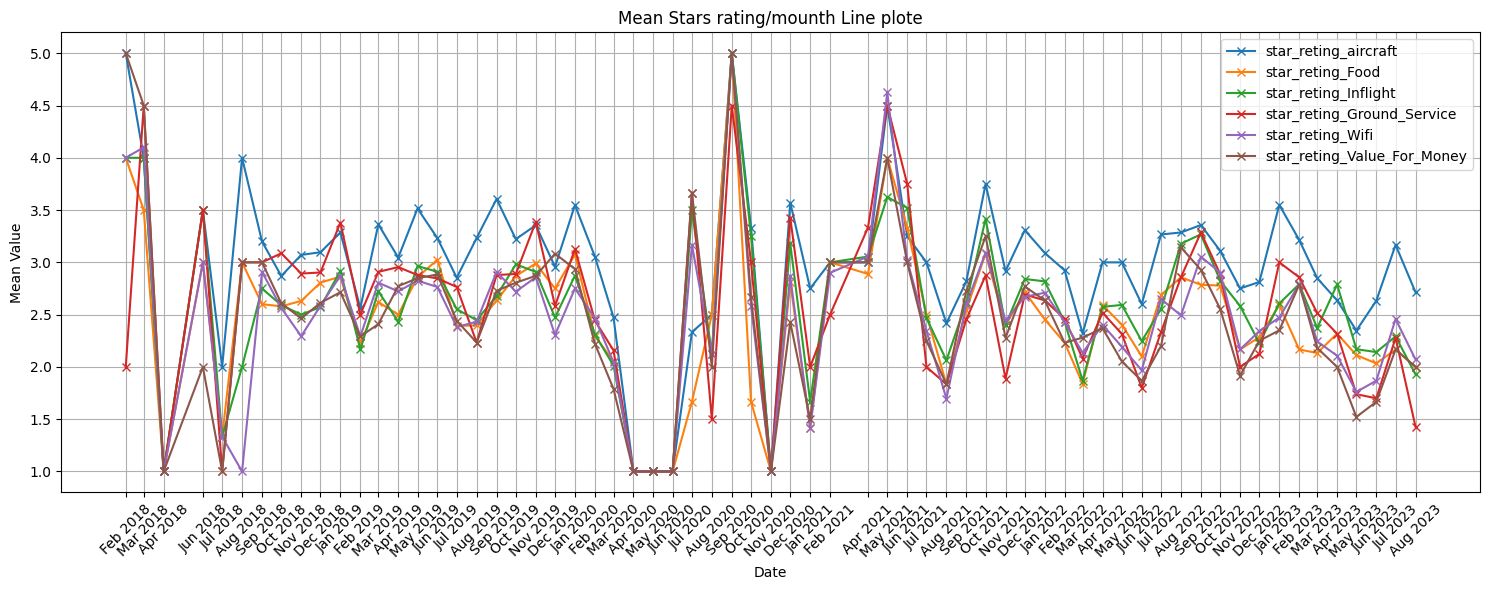

In [110]:
mean_star_ration = plt
mean_star_ration.figure(figsize=(15, 6))

for column_name in mean_stars_on_date_flown.columns:
    mean_star_ration.plot(mean_stars_on_date_flown.index, mean_stars_on_date_flown[column_name], '-x', label=column_name)

mean_star_ration.xlabel('Date')
mean_star_ration.ylabel('Mean Value')
mean_star_ration.title('Mean Stars rating/mounth Line plote')
mean_star_ration.legend()
mean_star_ration.grid(True)

# Set the x-axis ticks and labels to be months
mean_star_ration.xticks(mean_stars_on_date_flown.index, mean_stars_on_date_flown.index.strftime('%b %Y'), rotation=45) # type: ignore

mean_star_ration.tight_layout()

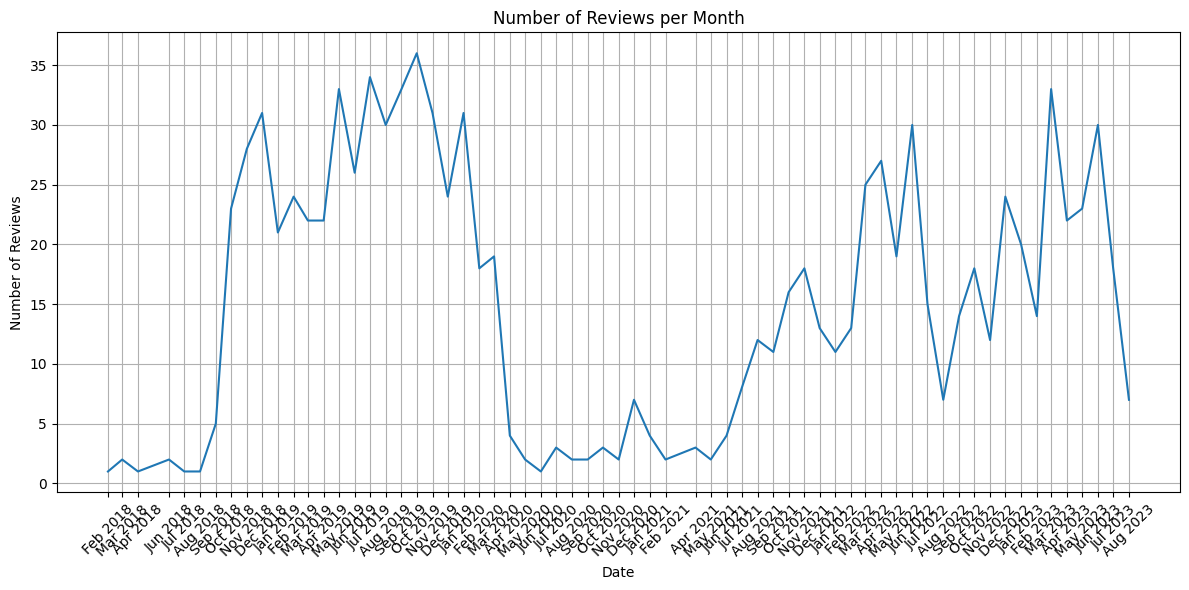

In [109]:
ploting_no_reviews_mounth = plt
reviews_count_per_month = reviews.groupby('Date_Flown')['name'].count()

ploting_no_reviews_mounth.figure(figsize=(12, 6))

ploting_no_reviews_mounth.plot(reviews_count_per_month.index, reviews_count_per_month, '')

ploting_no_reviews_mounth.xlabel('Date')
ploting_no_reviews_mounth.ylabel('Number of Reviews')
ploting_no_reviews_mounth.title('Number of Reviews per Month')
ploting_no_reviews_mounth.grid(True)

# Set the x-axis ticks and labels to be months
ploting_no_reviews_mounth.xticks(reviews_count_per_month.index, reviews_count_per_month.index.strftime('%b %Y'), rotation=45)

ploting_no_reviews_mounth.tight_layout()
ploting_no_reviews_mounth.show()


In [84]:
reviews.shape

(1000, 19)

In [85]:
reviews.to_csv("data/BA_reviews.csv")